In [1]:
# 1. Turn images into dataframe
# 2. Cluster images to see what types of similarities there are
# 3. See if these similarities reflect the sold/unsold boundary
# 4. Use clusters to tag images
# 5. Put images & tags into dataframe with metadata

In [5]:
# following this tutorial: https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb

In [8]:
!pip install opencv-python


    100% |████████████████████████████████| 39.7MB 538kB/s ta 0:00:011    82% |██████████████████████████▌     | 32.8MB 750kB/s eta 0:00:10
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
% matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

In [51]:
images = [] 
labels = [] # (sold or not sold)

    
for file in os.listdir('/Users/flatironschool/Final-Project/All-Images'):
    
    if os.path.getsize(f'/Users/flatironschool/Final-Project/All-Images/{file}') > 0:

        try:
    
        #   Read the image
            image = cv2.imread(f'/Users/flatironschool/Final-Project/All-Images/{file}')

        #   Resize it
            image = cv2.resize(image,(224,224))

        #   Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #   Now we add it to our array
            images.append(image)
            
            labels.append(file.split('-')[0])
            
        except:
            pass


In [52]:
len(labels)

1283

In [53]:
len(images)

1283

In [54]:
codes = ['SOLD', 'NOTSOLD']


2 random images for code SOLD


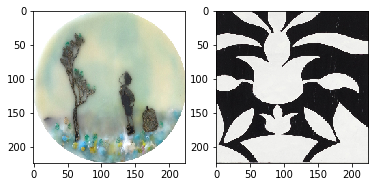

2 random images for code UNSOLD


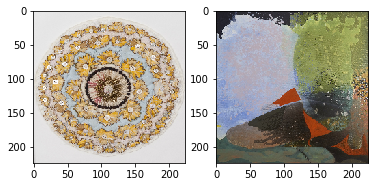

In [55]:
number_of_images_to_show=2

for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()
        
# It works!

In [56]:
# Normalizing before passing to VGG19

def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [58]:
images, labels = normalise_images(images, labels)

In [59]:
# Train test splitting (leave testing alone until end)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=20, random_state=123)


In [60]:
# Load pre-trained covnet models

# Testing out VGG16, VG19, ResNet50

# We'll now load up the keras models with the imagenet weights. We'll remove the top dense layers, since we won't need to classify things here, 
# and we just want these encoded features from the images.

# Load the models with ImageNet weights:

vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

80142336/80134624 [==============================] - 15s 0us/step


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 14s 0us/step


In [61]:
# The covnet models will give us 3D vectors that represent the image. We need to flatten these for the 
# clustering algorithms to start working with them:

def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat